## <center> École Polytechnique de Montréal <br> Département Génie Informatique et Génie Logiciel <br>  INF8460 – Traitement automatique de la langue naturelle <br> </center>
## <center> Annotation de questions avec Wikidata <br>  </center>

## Identification de l'équipe:

### Groupe de laboratoire: Groupe 3

### Équipe numéro : 1

### Membres:

LIEN POUR LE DRIVE: https://drive.google.com/drive/folders/1qI3tNn2NwHEjqOpne4UsgSdbagfrN525?usp=sharing

- Zachary Allaire (33 % de contribution, état de l'art + code pour modèle améliorée)
- Quentin Lao (33 % de contribution, modèle BERT + code pour modèle améliorée)
- Pierre Denis (33 % de contribution, modèle T5 + code pour modèle améliorée)

## 1. DESCRIPTION

Dans le cadre de ce projet, nous effectuerons une annotation de questions en langue naturelle en utilisant différents modèles avec pour objectif ultime de proposer une méthode qui dépasse les performances des équipes concurrentes.

Par exemple, étant donnée la question:
What is the country for head of state of Justin Trudeau ?
Votre modèle devra retourner :
what is the <\<wd:Q6256\>> for <\<wdt:P35\>> of <\<wd:Q3099714\>> ?

Les éléments ayant pour préfixe wd sont des URIs de Wikidata. Par exemple wd:Q6256 correspond à l'URI https://www.wikidata.org/wiki/Q6256

Wikidata est une base de données collaborative et structurée qui fait partie du projet Wikimedia, tout comme Wikipédia. Contrairement à Wikipédia, qui se concentre sur la création et la gestion de contenu encyclopédique, Wikidata se spécialise dans la collecte et la gestion de données structurées.

**Ressources Wikidata :**

Les ressources sont des entités du monde réel avec un identifiant unique précédé du préfixe "wd".

Voici quelques exemples d'éléments :

1. **La Tour Eiffel (Identifiant : Q243)** - Il s'agit d'un élément représentant la célèbre tour située à Paris.

2. **Albert Einstein (Identifiant : Q937)** - C'est un élément qui représente le physicien renommé.

3. **Mona Lisa (La Joconde) (Identifiant : Q12418)** - Un élément correspondant à l'œuvre d'art iconique de Leonardo da Vinci.

**Propriétés Wikidata :**

Les propriétés sont des caractéristiques ou des informations spécifiques associées aux éléments. Chaque propriété a un identifiant unique avec l'un des préfixes suivant: "wdt", "ps" ou "pq" et est utilisée pour décrire, quantifier ou qualifier les éléments. Voici des exemples de propriétés avec les éléments correspondants :

1. **Hauteur (Propriété : P2049)** - Une propriété utilisée pour indiquer la hauteur d'une structure. Par exemple, la hauteur de la Tour Eiffel est stockée dans cette propriété.

2. **Date de naissance (Propriété : P569)** - Une propriété pour enregistrer la date de naissance des individus. Par exemple, la date de naissance d'Albert Einstein est stockée grâce à cette propriété.

3. **Créateur (Propriété : P170)** - Cette propriété est utilisée pour spécifier qui a créé une œuvre d'art. Dans le cas de la Mona Lisa, on associe cette propriété à l'élément correspondant pour indiquer que Leonardo da Vinci en est le créateur.


Le jeu de données utilisé comprend des questions rédigées en langage naturel, ainsi que ces mêmes questions annotées avec des identifiants provenant de la base de connaissances Wikidata.

Pour illustrer ce jeu de données, voici un exemple :

| question_id |        question_raw        |                 question_original                 |              question_tagged               |
| :---------: | :------------------------: | :---------------------------------------------: | :---------------------------------------: |
|     1       | What is the country for head of state of Justin Trudeau | What is the {country} for {head of state} of {Justin Trudeau} | what is the <\<wd:Q6256\>> for <\<wdt:P35\>> of <\<wd:Q3099714\>> |


On peut trouver la correspondance des éléments dans les liens suivants:
- __{country}__ : https://www.wikidata.org/wiki/Q6256
- __{head of state}__ : https://www.wikidata.org/wiki/Property:P35
- __{Justin Trudeau}__ : https://www.wikidata.org/wiki/Q3099714  

# Import des bibliothèques

In [ ]:
!pip install transformers
!pip install accelerate -U
!pip install transformers[torch]
!pip install datasets
!pip install seqeval
!pip install sentencepiece

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 

#### Mount les Google Drive

In [ ]:
#Root pour Pierre
from google.colab import drive
drive.mount('/content/drive')
root = '/content/drive/MyDrive/data_tp4_nlp'

Mounted at /content/drive


In [ ]:
# Root pour Quentin

from google.colab import drive
drive.mount('/content/drive')
root = '/content/drive/MyDrive/NLP/data'

#root = 'data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Root pour Zach
from google.colab import drive
drive.mount('/content/drive')
root = '/content/drive/MyDrive/data_NLP_PROJECT'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Importer les données

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from collections import Counter
import plotly.express as px
import torch
from torch import nn
from transformers import BertTokenizer, BertForTokenClassification
from sklearn.metrics import f1_score, precision_score, recall_score
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast, GradScaler
from torch.optim import AdamW
from sklearn.metrics import f1_score
import gc
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW
from torch.utils.data import DataLoader, Dataset

#Import des données
train_set = pd.read_csv(f'{root}/TP_Data/train.csv', sep='|')
test_set = pd.read_csv(f'{root}/TP_Data/test.csv', sep='|')
validation_set = pd.read_csv(f'{root}/TP_Data/validation.csv', sep='|')

print(f"Train :")
display(train_set.head())

print(f"\n\nTest :")
display(test_set.head())

print(f"\n\nValidation :")
display(validation_set.head())


ressource_wikidata = ["wd:"]
property_wikidata = ["wdt:", "ps:", "pq:"]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Train :


,question_id,question_original,question_raw,question_tagged
0,1,What is {child of} of {husband} of {Ranavalona...,what is child of of husband of ranavalona i ?,what is <<wdt:P22>> of <<wdt:P26>> of <<wd:Q16...
1,2,Did {Jeff_Bridges} {occupation} {Lane Chandler...,did jeff _ bridges occupation lane chandler an...,did <<wd:Q174843>> <<wdt:P106>> <<wd:Q1804811>...
2,3,Give me {cola} that starts with {'p'},give me cola that starts with ' p ',give me <<wd:Q134041>> that starts with <<'p'>>
3,4,What is {prizewinner} of {sequel is} of {1885 ...,what is prizewinner of sequel is of 1885 wimbl...,what is <<wdt:P1346>> of <<wdt:P156>> of <<wd:...
4,5,Does the {carbon footprint} of the {iPhone Xs ...,does the carbon footprint of the iphone xs max...,does the <<wdt:P5991>> of the <<wd:Q56599233>>...




Test :


,question_id,question_raw
0,1,what is the country for head of state of mahmo...
1,2,"what is voice actresses of south park , that h..."
2,3,what is lakes on river of lake winnipeg ?
3,4,what is the open cluster with the max ( radius...
4,5,what is the end time for jonathan swift has re...




Validation :


,question_id,question_original,question_raw,question_tagged
0,1,What is the {essential medicine} for {medical ...,what is the essential medicine for medical con...,what is the <<wd:Q35456>> for <<wdt:P2175>> of...
1,2,what is the {pressure} for {copper} has {boili...,what is the pressure for copper has boiling po...,what is the <<pq:P2077>> for <<wd:Q753>> has <...
2,3,What is {played by} of {succeded by} of {Sleep...,what is played by of succeded by of sleepwalki...,what is <<wdt:P175>> of <<wdt:P156>> of <<wd:Q...
3,4,What is <total reserves> of <Tanzania> ?,what is total reserves of tanzania ?,what is <<wdt:P2134>> of <<wd:Q924>> ?
4,5,Did {Marketing} {facet of} {human communicatio...,did marketing facet of human communication and...,did <<wd:Q39809>> <<wdt:P1269>> <<wd:Q1066689>...


#### Cleaning

On remarque que les mots clés sont pas interceptés de la même manière dans toute la colonne "question_original". La plupart du temps, c'est entre brackets "{...}" mais il y a aussi quelques cas où c'est "<...>"
==> On uniformise cela

In [ ]:
def cleaning(sentence) :

    #Enlève les majuscules
    sentence = sentence.lower()

    #Si on trouve <, on remplace par {.
    sentence = sentence.replace("<", "{")
    sentence = sentence.replace(">", "}")

    #Y'a parfois des {{ qui trainent --> on transforme en {
    sentence = sentence.replace("{{", "{")
    sentence = sentence.replace("}}", "}")

    return sentence

train_set['question_original'] = train_set['question_original'].apply(cleaning)
validation_set['question_original'] = validation_set['question_original'].apply(cleaning)

# Analyse exploratoire


### Détermination du nombre d'identifiants uniques du jeu d'entrainement


In [ ]:
def get_keyword(df, columns_name):
    """
        Compte les doublons
    """

    keywords = []

    for index, row in tqdm(df.iterrows(), total=df.shape[0]):

        keywords += re.findall(r'<<(.+?)>>', row["question_tagged"])

    return keywords



train_keyword = get_keyword(train_set, "question_tagged")
print(f"\nLe nombre de mots clés dans le train est de {len(set(train_keyword))}")

100%|██████████| 19603/19603 [00:02<00:00, 9302.67it/s]


Le nombre de mots clés dans le train est de 22553


### Détermination du pourcentage d'identifiants uniques inconnus du jeu de validation.


In [ ]:
validation_keyword = get_keyword(validation_set, "question_tagged")
print(f"Le nombre de mots clés dans validation est de {len(set(validation_keyword))}")

# On regarde les mots clés qui sont dans le validation mais pas dans le train
difference = list(set(validation_keyword) - set(train_keyword))

print(f"\nPourcentage de mots clés inconnus dans le train : {len(difference)/len(set(validation_keyword))*100:.2f}%")

100%|██████████| 2183/2183 [00:00<00:00, 5934.43it/s]

Le nombre de mots clés dans validation est de 4062

Pourcentage de mots clés inconnus dans le train : 41.93%


### Détermination des 10 identifiants uniques les plus fréquents du jeu d'entrainement.


In [ ]:
# Compte les 10 mots clés les plus fréquents dans le train
counter = Counter(train_keyword)
ten_most_common = counter.most_common(10)


#Plot les 10 mots clés les plus fréquents dans le train dans un barplot avec plotly
fig = px.bar(x=[x[0] for x in ten_most_common], y=[x[1] for x in ten_most_common], labels={'x':'Mots clés', 'y':'Nombre de mots clés'}, title="Les 10 mots clés les plus fréquents dans le train")
fig.show()


### Déterminnation de la proportion des identifiants uniques qui sont des ressources Wikidata.

In [ ]:
def keyword_type( keywords ) :
    """
    Renvoie un dataframe avec les mots clés (unique) et leur type
    """

    unique_keywords = list(set(keywords))
    keyword_type = {}

    for keyword in unique_keywords :
        ktype = None

        for ressource in ressource_wikidata :
            if ressource in keyword :
                ktype = "ressource"
                break

        for prop in property_wikidata :
            if prop in keyword :
                ktype = "property"
                break

        keyword_type[keyword] = ktype if ktype is not None else "other"

    #Pandas dataframe
    keyword_type = pd.DataFrame.from_dict(keyword_type, orient='index', columns=['type'])
    keyword_type = keyword_type.reset_index().rename(columns={'index':'keyword'})

    return keyword_type

train_keyword_type = keyword_type(train_keyword)
#train_keyword_type = keyword_type(train_keyword + validation_keyword) #Si on veut prendre en compte les mots clés du validation

# Compte le nombre de mots clés par type
train_keyword_type_count = train_keyword_type.groupby('type').count().reset_index().rename(columns={'keyword':'count'})

#Plot dans un pie chart
fig = px.pie(train_keyword_type_count, values='count', names='type', title="Répartition des types de mots clés dans le train")
fig.show()

### Détermination de la fréquence de chaque entité Wikidata du jeu d'entrainement, ordonnée par fréquence décroissante et affichez une courbe fréquence - rang.

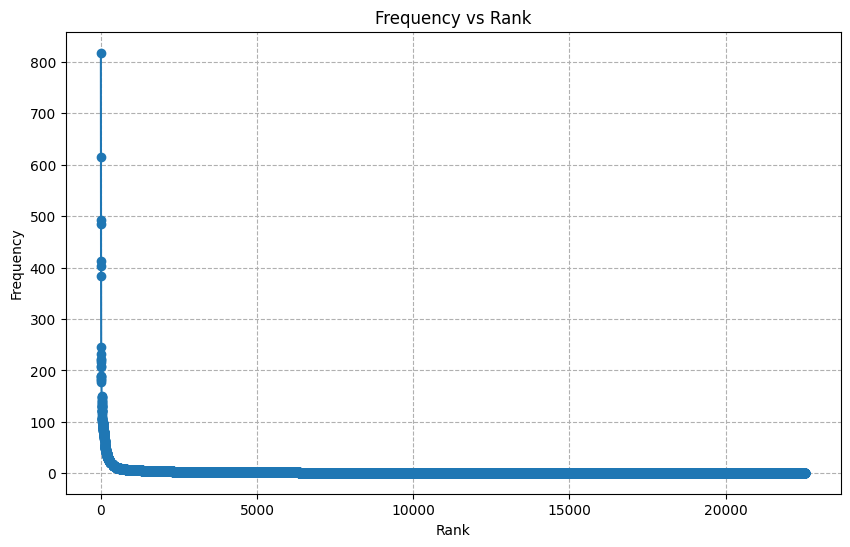

In [ ]:
# Remplacer par ma fonction vu que celle de quentin affiche pas les chiffres?

count = Counter(train_keyword).most_common()

frequencies = sorted([freq for _, freq in count], reverse=True)

# Get the ranks
ranks = np.arange(1, len(frequencies) + 1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(ranks, frequencies, marker='o', linestyle='-')
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.title("Frequency vs Rank")
plt.grid(True, which="both", ls="--")
plt.show()

# Approche 1 : classification de jeton

Nous allons entrainer un modèle (BERT, ROBERTA, etc.) pour classifier les jetons du __question_original__ avec le bon identifiant de Wikidata.

Sera utilisé le format BIO afin d'effectuer la classification.

Ainsi, si une entité se retrouve dans plusieurs jetons, le début de l'entité est indiqué par le préfixe __B-__ à la classe. Un jeton faisant partie de l'entité doit avoir le préfixe __I-__ à la classe.

Lorsqu'un jeton ne fait pas partie d'une entité, celui-ci devrait avoir la classe __O__

__Exemple:__

Jeu de validation:

|   question_id   |                  question_original                           |
|    :----:       | :----------------------------------------------:             |
|      1          | What is the {country} for {head of state} of {Justin Trudeau} |




In [ ]:
def tokenize_question_original(sentence) :
    """
        Tokenize les questions originales.
    """

    #Tokenize la phrase
    tokens = word_tokenize(sentence)

    return tokens


def is_wikidata(word) :
    ressource_wikidata = ["wd:"]
    property_wikidata = ["wdt:", "ps:", "pq:"]

    for res in ressource_wikidata :
        if res in word :
            return True
    for prop in property_wikidata :
        if prop in property_wikidata :
            return True
    return False


def label_question_original(tokens, question_tagged) :
    """
        Labelise les questions originales (on s'aide des questions taggées)
    """

    #Récupère les mots clés
    keywords = re.findall(r'<<(.+?)>>', question_tagged)

    #Check que le nombre de mots clés est le même que le nombre de "{" que dans tokenize_sentence
    assert len(keywords) == tokens.count("{"), f"L'expression <<{keywords}>> ne correspond pas à la phrase {tokens}"

    labels = []
    cur_keyword = 0
    in_keyword = False
    for i,token in enumerate(tokens) :
        if in_keyword :
            if is_wikidata(keywords[cur_keyword]) :
                labels.append("I-" + keywords[cur_keyword])
                if token == "}" :
                    cur_keyword += 1
                    in_keyword = False
            else :
                in_keyword = False
                labels = labels[:-1] + ["O", "O"]
        else :
            if token == "{" :
                labels.append("B-" + keywords[cur_keyword])
                in_keyword = True
            else :
                labels.append("O")

    return labels

def create_vocab(df, reserved_tokens = [], filename = "vocab", threshold = 1):

    #Récupère tous les tokens
    dict_vocab = {}
    for tokens_sentence in df["tokens"].tolist() :
        for token in tokens_sentence :
            if token not in dict_vocab :
                dict_vocab[token] = 1
            else :
                dict_vocab[token] += 1

    #Récupère les tokens qui apparaissent plus de threshold fois
    with open(f"{filename}.txt",'w') as f:
        for token, count_token in dict_vocab.items() :
            if count_token >= threshold :
                f.write(f'{token.lower()}\n')
        for token in reserved_tokens :
            f.write(f'{token}\n')



    #Récupère tous les labels
    dict_labels = {}
    for labels_sentence in df["labels"].tolist() :
        for label in labels_sentence :
            if label != "O" :
                if label not in dict_labels :
                    dict_labels[label] = 1
                else :
                    dict_labels[label] += 1

    #Récupère les labels qui apparaissent plus de threshold fois
    with open(f"{filename}_label.txt",'w') as f:
        for label, count_label in dict_labels.items() :
            if count_label >= threshold :
                f.write(f'{label}\n')
        for label in reserved_tokens :
            f.write(f'{label}\n')


#Train set
train_set["tokens"] = train_set["question_original"].apply(tokenize_question_original)
train_set["labels"] = train_set.apply(lambda row : label_question_original(row["tokens"], row["question_tagged"]), axis=1)
reserved_tokens = ['[PAD]','[UNK]','[SEP]','O','[CLS]']
create_vocab(train_set, reserved_tokens = reserved_tokens)

display(train_set.head())

#Val set
validation_set["tokens"] = validation_set["question_original"].apply(tokenize_question_original)
validation_set["labels"] = validation_set.apply(lambda row : label_question_original(row["tokens"], row["question_tagged"]), axis=1)

,question_id,question_original,question_raw,question_tagged,tokens,labels
0,1,what is {child of} of {husband} of {ranavalona...,what is child of of husband of ranavalona i ?,what is <<wdt:P22>> of <<wdt:P26>> of <<wd:Q16...,"[what, is, {, child, of, }, of, {, husband, },...","[O, O, B-wdt:P22, I-wdt:P22, I-wdt:P22, I-wdt:..."
1,2,did {jeff_bridges} {occupation} {lane chandler...,did jeff _ bridges occupation lane chandler an...,did <<wd:Q174843>> <<wdt:P106>> <<wd:Q1804811>...,"[did, {, jeff_bridges, }, {, occupation, }, {,...","[O, B-wd:Q174843, I-wd:Q174843, I-wd:Q174843, ..."
2,3,give me {cola} that starts with {'p'},give me cola that starts with ' p ',give me <<wd:Q134041>> that starts with <<'p'>>,"[give, me, {, cola, }, that, starts, with, {, ...","[O, O, B-wd:Q134041, I-wd:Q134041, I-wd:Q13404..."
3,4,what is {prizewinner} of {sequel is} of {1885 ...,what is prizewinner of sequel is of 1885 wimbl...,what is <<wdt:P1346>> of <<wdt:P156>> of <<wd:...,"[what, is, {, prizewinner, }, of, {, sequel, i...","[O, O, B-wdt:P1346, I-wdt:P1346, I-wdt:P1346, ..."
4,5,does the {carbon footprint} of the {iphone xs ...,does the carbon footprint of the iphone xs max...,does the <<wdt:P5991>> of the <<wd:Q56599233>>...,"[does, the, {, carbon, footprint, }, of, the, ...","[O, O, B-wdt:P5991, I-wdt:P5991, I-wdt:P5991, ..."


In [ ]:
class MyClassifier(nn.Module) :

    reserved_tokens = ['[PAD]','[UNK]','[SEP]','O','[CLS]']
    model_checkpoint = "bert-base-uncased"

    def __init__(self, model_name = "model") :
        super().__init__()

        #Retiens nombre d'époques entrainées
        self.trained_epochs = 0

        #Nom du model
        self.model_name = model_name

        #Tokenizers
        self.bert_tokenizer = BertTokenizer(
            vocab_file = 'vocab.txt',
            never_split = MyClassifier.reserved_tokens,
        )
        self.bert_tokenizer_label = BertTokenizer(
            vocab_file = 'vocab_label.txt',
            never_split = MyClassifier.reserved_tokens,
        )


        #Device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


        #Modèle BERT pré-entrainé
        self.bert = BertForTokenClassification.from_pretrained(
            MyClassifier.model_checkpoint,
            num_labels = self.bert_tokenizer_label.vocab_size
        )
        self.bert.to(self.device)


        #criterion
        self.criterion = nn.CrossEntropyLoss(ignore_index = self.bert_tokenizer_label.pad_token_id)



    def create_dataset(self, df) :
        """
            Crée le dataset à partir du dataframe
        """

        #Liste des input_ids et les attention_mask
        input_ids = []
        attention_mask = []
        for tokens in df["tokens"].tolist() :
            encoded = self.bert_tokenizer.encode_plus(
                tokens,
                add_special_tokens = True,
                max_length = 128,
                padding = "max_length",
                truncation = True,
                return_attention_mask = True,
                return_tensors = "pt"
            )
            input_ids.append(encoded["input_ids"])
            attention_mask.append(encoded["attention_mask"])


        #Liste des labels
        labels = []
        for labels_sentence in df["labels"].tolist() :
            encoded = self.bert_tokenizer_label.encode_plus(
                labels_sentence,
                add_special_tokens = False,
                max_length = 128,
                padding = "max_length",
                truncation = True,
                return_attention_mask = False,
                return_tensors = "pt"
            )
            labels.append(encoded["input_ids"])

        #Crée le dataset
        dataset = TensorDataset(
            torch.cat(input_ids, dim=0),
            torch.cat(attention_mask, dim=0),
            torch.cat(labels, dim=0)
        )


        return dataset


    def train(self, train_set, validation_set, batch_size = 32, epochs = 10, lr = 1e-5, save_strategy = "no", save_root = root) :
        """
            Entraîne le modèle

            save_strategy : "no" (aucune sauvegarde), "epoch" (à chaque époque. idem que 1) ou int (nombre d'epoch avant sauvegarde)
        """

        #Conversion panda df -> dataset
        train_dataset = self.create_dataset(train_set)
        validation_dataset = self.create_dataset(validation_set)

        #Dataloaders
        train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
        validation_dataloader = DataLoader(validation_dataset, batch_size = batch_size, shuffle = False)

        #Optimizer
        optimizer = torch.optim.AdamW(self.bert.parameters(), lr = lr)

        #Crée le scaler
        scaler = GradScaler()



        for epoch in range(epochs) :

            ##################################
            ########## Entraînement ##########
            ##################################
            self.bert.train()
            train_loss = 0
            train_f1 = 0
            for batch in tqdm(train_dataloader, desc = f"Epoch {epoch+1}/{epochs} : Training") :

                #Récupère les inputs + spécifie le device
                input_ids = batch[0].to(self.device)
                attention_mask = batch[1].to(self.device)
                labels = batch[2].to(self.device)

                #Forward
                with autocast() :
                    outputs = self.bert(
                        input_ids = input_ids,
                        attention_mask = attention_mask,
                        labels = labels
                    )
                    logits = outputs.logits
                    loss = self.loss(logits, labels)

                #Backward
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                optimizer.zero_grad()

                #On calcule la train loss + F1
                train_loss += loss.item()
                train_f1 += self.compute_f1_score(logits, labels)




            ##################################
            ########### VALIDATION ###########
            ##################################
            self.bert.eval()
            validation_loss = 0
            validation_f1 = 0

            tabulation = " "*len(f"Epoch {epoch+1}/{epochs} : ") #Pretty print
            for batch in tqdm(validation_dataloader, desc = f"{tabulation}Validation") :

                #Récupère les inputs
                input_ids = batch[0].to(self.device)
                attention_mask = batch[1].to(self.device)
                labels = batch[2].to(self.device)

                #Forward
                with torch.no_grad() :
                    outputs = self.bert(
                        input_ids = input_ids,
                        attention_mask = attention_mask,
                        labels = labels
                    )
                    logits = outputs.logits
                    loss = self.loss(logits, labels)

                #On calcule la validation loss + F1
                validation_loss += loss.item()
                validation_f1 += self.compute_f1_score(logits, labels)




            ##################################
            ########### PRINT STAT ###########
            ##################################
            print(f"\tTrain loss : {round( train_loss/len(train_dataloader) , 3)}")
            print(f"\tTrain F1 : {round( train_f1/len(train_dataloader) , 3)}")
            print(f"\tValidation loss : {round( validation_loss/len(validation_dataloader) , 3)}")
            print(f"\tValidation F1 : {round( validation_f1/len(validation_dataloader) , 3)}")
            print("")

            self.trained_epochs += 1


            ##################################
            ########## SAVING MODEL ##########
            ##################################
            if "int" in str(type(save_strategy)) and self.trained_epochs%save_strategy == 0 :
                self.save_model(f"{save_root}/{self.trained_epochs}_{self.model_name}.pt")
            elif "str" in str(type(save_strategy)) and "epoch" in save_strategy: #String
                self.save_model(f"{save_root}/{self.trained_epochs}_{self.model_name}.pt")




    def compute_f1_score(self, logits, labels, average = "macro") :
        """
            Calcule le f1 score
        """

        #Récupère les prédictions
        predictions = torch.argmax(logits, dim=2)

        #Récupère les masques
        mask = labels != self.bert_tokenizer_label.pad_token_id

        #Calcule le f1 score
        f1 = f1_score(
            labels[mask].cpu().numpy().flatten(),
            predictions[mask].cpu().numpy().flatten(),
            average = average
        )

        return f1


    def loss(self, logits, labels) :
        """
            Calcule la loss
        """

        mask = labels != self.bert_tokenizer_label.pad_token_id

        #Calcule la loss
        loss = self.criterion(
            logits[mask].reshape(-1, self.bert_tokenizer_label.vocab_size),
            labels[mask].reshape(-1)
        )

        return loss


    def predict(self, tokenized_sentences) :
        """
            Prédit les labels d'une phrase
        """

        input_ids, attention_mask, tokens_list = [], [], []

        for tokens in tokenized_sentences :

            #Crée les input_ids et les attention_mask

            encoded = self.bert_tokenizer.encode_plus(
                tokens,
                add_special_tokens = True,
                max_length = 128,
                padding = "max_length",
                truncation = True,
                return_attention_mask = True,
                return_tensors = "pt"
            )
            input_ids.append(encoded["input_ids"])
            attention_mask.append(encoded["attention_mask"])


        #Crée le dataset
        dataset = TensorDataset(
            torch.cat(input_ids, dim=0),
            torch.cat(attention_mask, dim=0),
        )

        #Crée le dataloader
        batch_size = min(32, len(tokenized_sentences))
        dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = False)


        #List de le list des labels de chaque phrase
        labels = []

        #Prédiction
        self.bert.eval()
        for batch_nb, batch in tqdm(enumerate(dataloader), desc = f"Prediction", total = len(tokenized_sentences)//batch_size) :

            #Récupère les inputs
            input_ids = batch[0].to(self.device)
            attention_mask = batch[1].to(self.device)

            #Forward
            with torch.no_grad() :
                outputs = self.bert(
                    input_ids = input_ids,
                    attention_mask = attention_mask,
                )
                logits = outputs.logits

            #Récupère les prédictions
            predictions = torch.argmax(logits, dim=2)

            for j in range(len(predictions)) :
                sub_list_label = []
                tokens = tokenized_sentences[batch_nb*batch_size + j]

                for i,token in enumerate(tokens) :
                    label = self.bert_tokenizer_label.convert_ids_to_tokens(predictions[j][i].item())
                    sub_list_label.append(label)
                labels.append(sub_list_label)

        return labels


    def save_model(self,save_path = "model.pt") :
        """
            Sauvegarde le model
        """
        torch.save(self.bert.state_dict(), save_path)

    def load_model(self, path) :
        """
            Charge un modèle
        """

        self.bert.load_state_dict(torch.load(path, map_location=self.device))

#### Bloc pour le debugging du modèle

In [ ]:
clf = MyClassifier()
clf.load_model(f"{root}/model.pt")

example_sentences = ["what is the {country of citizenship} and the {publisher} of {Soviet_Union} ?", "what is the {publisher} and the {country of citizenship} of {Soviet_Union} ?"]
tokenized_senteces = [word_tokenize(sentence) for sentence in example_sentences] #Utilise le tokenizer qui a entrainé le classifier
labels = clf.predict(tokenized_senteces)

print("\n\n====== Predictions sentences ======\n")
for sentence, predict_sentence in zip(example_sentences, labels) :
    print(f"{sentence} :\n --> {predict_sentence}\n")


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Prediction: 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]



====== Predictions sentences ======

what is the {country of citizenship} and the {publisher} of {Soviet_Union} ? :
 --> ['O', 'O', 'O', 'B-wdt:P27', 'I-wdt:P27', 'I-wdt:P27', 'I-wdt:P27', 'I-wdt:P27', 'O', 'O', 'B-wdt:P123', 'I-wdt:P123', 'I-wdt:P123', 'O', 'B-wd:Q240', 'I-wd:Q201927', 'I-wd:Q201927', 'O']

what is the {publisher} and the {country of citizenship} of {Soviet_Union} ? :
 --> ['O', 'O', 'O', 'B-wdt:P123', 'I-wdt:P123', 'I-wdt:P123', 'O', 'O', 'B-wdt:P27', 'I-wdt:P27', 'I-wdt:P27', 'I-wdt:P27', 'I-wdt:P27', 'O', 'B-wd:Q201927', 'I-wd:Q201927', 'I-wd:Q201927', 'O']



In [ ]:
n_epochs = 20
lr = 5e-5

clf = MyClassifier()
clf.train(train_set, validation_set, epochs = n_epochs, lr = lr)
clf.save_model(save_path = f"{root}/model_final_Zach_BERT.pt")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
             Validation: 100%|██████████| 69/69 [00:06<00:00, 10.35it/s]


	Train loss : 7.007
	Train F1 : 0.003
	Validation loss : 6.192
	Validation F1 : 0.01



             Validation: 100%|██████████| 69/69 [00:10<00:00,  6.79it/s]


	Train loss : 5.904
	Train F1 : 0.023
	Validation loss : 5.652
	Validation F1 : 0.069



             Validation: 100%|██████████| 69/69 [00:07<00:00,  9.65it/s]


	Train loss : 5.217
	Train F1 : 0.071
	Validation loss : 5.051
	Validation F1 : 0.142



             Validation: 100%|██████████| 69/69 [00:07<00:00,  9.48it/s]


	Train loss : 4.556
	Train F1 : 0.139
	Validation loss : 4.561
	Validation F1 : 0.254



             Validation: 100%|██████████| 69/69 [00:06<00:00,  9.94it/s]


	Train loss : 4.01
	Train F1 : 0.198
	Validation loss : 4.221
	Validation F1 : 0.302



             Validation: 100%|██████████| 69/69 [00:06<00:00, 10.19it/s]


	Train loss : 3.592
	Train F1 : 0.238
	Validation loss : 4.02
	Validation F1 : 0.342



             Validation: 100%|██████████| 69/69 [00:07<00:00,  9.45it/s]


	Train loss : 3.232
	Train F1 : 0.267
	Validation loss : 3.838
	Validation F1 : 0.367



             Validation: 100%|██████████| 69/69 [00:06<00:00, 10.09it/s]


	Train loss : 2.899
	Train F1 : 0.296
	Validation loss : 3.698
	Validation F1 : 0.402



             Validation: 100%|██████████| 69/69 [00:08<00:00,  8.62it/s]


	Train loss : 2.593
	Train F1 : 0.328
	Validation loss : 3.579
	Validation F1 : 0.419



              Validation: 100%|██████████| 69/69 [00:06<00:00, 10.32it/s]


	Train loss : 2.307
	Train F1 : 0.365
	Validation loss : 3.484
	Validation F1 : 0.436



              Validation: 100%|██████████| 69/69 [00:06<00:00, 10.34it/s]


	Train loss : 2.041
	Train F1 : 0.408
	Validation loss : 3.436
	Validation F1 : 0.455



              Validation: 100%|██████████| 69/69 [00:06<00:00, 10.25it/s]


	Train loss : 1.789
	Train F1 : 0.457
	Validation loss : 3.371
	Validation F1 : 0.478



              Validation: 100%|██████████| 69/69 [00:06<00:00, 10.17it/s]


	Train loss : 1.554
	Train F1 : 0.518
	Validation loss : 3.346
	Validation F1 : 0.495



              Validation: 100%|██████████| 69/69 [00:06<00:00, 10.31it/s]


	Train loss : 1.335
	Train F1 : 0.584
	Validation loss : 3.32
	Validation F1 : 0.507



Epoch 15/20 : Training:  35%|███▍      | 214/613 [00:25<00:46,  8.53it/s]


KeyboardInterrupt: ignored

Par souci de temps, l'entrainement a été arreter à 14 époques. Le "average F1 macro score" maximal obtenu est donnée par la dernière itération et celui-ci est de 0.507

# Approche 2 : Approche générative

Nous allons entrainer un modèle séquence à séquence de type T5 partant de la __question_raw__ et qui génére la __question_tagged__ correspondante.

__Exemple:__

Jeu de validation:

|   question_id   |                  question_raw                          |
|    :----:       | :----------------------------------------------:            
|      1          | What is the country for head of state of Justin Trudeau |


__Entrée du modèle:__ What is the country for head of state of Justin Trudeau

__Prédiction du modèle__:  what is the <\<wd:Q6256\>> for <\<wdt:P35\>> of <\<wd:Q3099714\>>



In [ ]:
# Pour importer un modèle entrainé

from transformers import T5Tokenizer, T5ForConditionalGeneration

# Path aux modèles
model_dir = root+'/Models/T5_v2'

# Charger le modèle et le tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-base')
tokenizer.add_tokens(["<<"])
model = T5ForConditionalGeneration.from_pretrained(model_dir)
model.resize_token_embeddings(len(tokenizer))
model.eval()
model = model.cuda()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Helper function pour prédire

def generate_answers(questions, batch_size=32):
    answers = []
    prompt = "convert: "
    for i in range(0, len(questions), batch_size):
        batch_questions = [prompt + q for q in questions[i:i+batch_size]]
        inputs = tokenizer(batch_questions, return_tensors="pt", padding=True, truncation=True, max_length=50).to('cuda')
        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=128)
        batch_answers = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
        answers.extend(batch_answers)
    return answers

# Ajouter une colonne à notre ensemble de validation
validation_set['t5_pred'] = generate_answers(validation_set['question_raw'].tolist())

# Parfois t5 rajoute un espace avant les << dans les prédictions, si le cas:
#validation_set['t5_pred'] = validation_set['t5_pred'].apply(lambda x: x.replace("<< ","<<"))


In [ ]:
# Charger les données dans le format voulu avant l'entrainement

class T5Dataset(Dataset):
    def __init__(self, tokenizer, data, max_length=50):
        self.tokenizer = tokenizer
        self.data = data
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        input_text = f"convert: {item['question_raw']}"  # Add prefix here
        input = self.tokenizer.encode_plus(
            input_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        target = self.tokenizer.encode_plus(
            item['question_tagged'],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return input, target


# Initialiser le modèle et le tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-base')
tokenizer.add_tokens(["<<"])
model = T5ForConditionalGeneration.from_pretrained('t5-base')
model.resize_token_embeddings(len(tokenizer))
model = model.cuda()

# Preparer le dataset et le DataLoader
dataset = T5Dataset(tokenizer, train_set[['question_raw','question_tagged']])
loader = DataLoader(dataset, batch_size=32, shuffle=True)  # Ajuster le batch_size si on veut

In [ ]:
# Entrainer le modèle

# Optimiseur
optimizer = AdamW(model.parameters(), lr=5e-5)

# Pour 8 epoch --> 1h entrainement sur T4
model.train()
for epoch in range(8):
    for batch in loader:
        input, target = batch
        input_ids = input['input_ids'].squeeze(1).cuda()
        target_ids = target['input_ids'].squeeze(1).cuda()

        outputs = model(input_ids=input_ids, labels=target_ids)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

        # Libérer la mémoire
        del input_ids, target_ids, loss
        torch.cuda.empty_cache()
        gc.collect()

# Sauvegarder le modèle
model.save_pretrained(root+'models/v2/')

In [ ]:

def extract_identifiers(text):
    pattern = r"wdt?:[QP]\d+"
    return re.findall(pattern, text)

# Extraction des identifiants attendus
identifiers_expected = [extract_identifiers(row) for row in validation_set['t5_pred']]

identifiers_predicted = [extract_identifiers(row) for row in validation_set['question_tagged']]


In [ ]:
def normalise_predictions(predicted,expected):
  for i in range(len(predicted)):
    if len(predicted[i]) == 0:
      predicted[i] = 'UNK'
    if len(predicted[i]) > len(expected[i]):
      for j in range(len(predicted[i])):
        if predicted[i][j] not in expected[i]:
          predicted[i].remove(predicted[i][j])
        if len(predicted[i]) == len(expected[i]):
          break
    if len(predicted[i]) < len(expected[i]):
      pad_length = len(expected[i]) - len(predicted[i])
      predicted[i] = predicted[i] + pad_length*['UNK']


In [ ]:
normalise_predictions(identifiers_predicted, identifiers_expected)

In [ ]:
import numpy as np

def compute_metrics(preds, trues):
    flat_predictions = [item for sublist in preds for item in sublist]
    flat_true = [item for sublist in trues for item in sublist]

    # Calculer precision, recall, et F1 score
    flat_true_classes = list(set(flat_true))
    precision = precision_score(flat_true, flat_predictions, average='macro', zero_division=0, labels=flat_true_classes)
    recall = recall_score(flat_true, flat_predictions, average='macro', zero_division=0, labels=flat_true_classes)
    f1 = f1_score(flat_true, flat_predictions, average='macro', zero_division=0, labels=flat_true_classes)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [ ]:
compute_metrics(identifiers_predicted, identifiers_expected)

{'precision': 0.3474212680348597,
 'recall': 0.33395625843137283,
 'f1': 0.335809550156384}

# Approche personnalisée

On tente de proposer ici une approche plus complexe.

### État de l’art


Mots-clés: NER, apprentissage profond, réseaux de neurones, BERT, CRF, LSTM


Synthèse:

Les premières approches entourant le problème de NER (named entity recognition) utilisaient majoritairement des modèles statistiques ou des modèles basés sur des règles. Cela dit, depuis la création des réseaux de neurones, ceux-ci sont de plus en plus utilisés dans le NER et obtiennent d'excellents résultats. Zhai et al. [1] offrent un excellent résumer de différentes architectures qui ont été utilisées depuis 2003. En termes de l'architecture qui offrent les meilleurs résultats, celle-ci est donnée par [2] et [3]. L'architecture de [2] est en fait la combinaison de BERT et de GRU alors que l'architecture de [3] est basé sur BERT combiné avec un LSTM-CRF. Les modèles offrent une performance similaire avec un score F1 de 91.96 sur le CoNLL-2003.

Au-delà de l'architecture, différentes stratégies peuvent être utilisées pour essayer d'augmenter la performance des modèles choisis. Premièrement, l'ajout de ressource externe tel que des "gazeteer" [4]. Ceux-ci sont simplement des collections de noms d'entités communs qui sont organisées par type. Les "gazeteer" peuvent être utilisés afin de rajouter de l'information supplémentaire au modèle, puisqu'assez souvent, la performance d'un modèle est limitée par la quantité de données présente. Deuxièmement, une stratégie qui est peut mentionner dans la littérature est d'utiliser un tagging POS (part of speech) afin d'augmenter la quantité d'informations disponibles pour le modèle. Finalement, bien que ce n'est pas le cas dans notre application, il est important de mentionner qu'une partie de la recherche est orientée vers la gestion de tokens plus complexe [5] et l'amélioration de la performance dans des applications in situ [6]



Références:

[1] Zhai H, Lv X, Hou Z, Tong X, Bu F. MLNet: a multi-level multimodal named entity recognition architecture. Front Neurorobot. 2023 Jun 20;17:1181143. doi: 10.3389/fnbot.2023.1181143. PMID: 37408584; PMCID: PMC10319056.

[2] GCDT: A Global Context Enhanced Deep Transition Architecture for Sequence Labeling (Liu et al., ACL 2019)

[3] Luo, Y., Xiao, F., & Zhao, H. (2019). Hierarchical Contextualized Representation for Named Entity Recognition (arXiv:1911.02257). arXiv. http://arxiv.org/abs/1911.02257

[4] Song, C. H., Lawrie, D., Finin, T., & Mayfield, J. (n.d.). Improving Neural Named Entity Recognition with Gazetteers.

[5] Ji, L., Yan, D., Cheng, Z. et al. Improving unified named entity recognition by incorporating mention relevance. Neural Comput & Applic 35, 22223–22234 (2023). https://doi.org/10.1007/s00521-023-08820-6

[6] Yu, B., Hu, Y., Mang, Q., Hu, W., & He, P. (2023). Automated Testing and Improvement of Named Entity Recognition Systems (arXiv:2308.07937). arXiv. http://arxiv.org/abs/2308.07937


### Architecture proposée

Notre architecture proposée se divise en deux parties; une classification en utilisant BERT pour déterminer s'il s’agit d'une propriété ou d'une entité, puis une recherche de mots similaires basée sur une base de connaissances.

La première étape consiste à entraîner notre modèle BERT à prédire la classe dans laquelle nous appartenons. Pour ce faire, nous l'entraînons sur une tâche de classification en utilisant les préfixes des identifiants wikidata. Cette première étape nous permet de filtrer ensuite notre base de connaissances afin d'obtenir les mots appartenant aux bonnes classes. La deuxième étape consiste à monter une base de connaissance basée sur notre ensemble d'entraînement, ainsi que des données externes en .json qui comporte des phrases avec des termes Wikidata et leurs identifiants respectifs. Notre base de connaissance est alors constituée de mots avec leurs tags, ainsi que leurs embeddings, générés par BERT afin de garder un contexte. Finalement, notre processus de classification consistera à identifier les mots à classifier, puis à utiliser une mesure de similarité pour trouver la similarité cosinus entre les embeddings de notre mot et des mots de notre base de connaissance, filtrée selon la nature de l'identifiant (P ou Q).

### Étape 1: Créer les dictionnaires d'items et de propriétés

In [ ]:
train_json = pd.read_json(f'{root}/json_added_data/wikidata-disambig-train.json')
test_json = pd.read_json(f'{root}/json_added_data/wikidata-disambig-dev.json')
validation_json = pd.read_json(f'{root}/json_added_data/wikidata-disambig-test.json')
train_json.head()

,correct_id,string,text,wrong_id
0,Q534153,captain marvel,fantasy novelist David Gemmell. Achilles is f...,Q41421
1,Q121378,corfu,"the city of Corfu Greece, Empress of Austria ...",Q3453113
2,Q38012,hera,a tale which offers an alternative version of...,Q37162645
3,Q192931,pausanias,"mention the spear, which he would indeed have...",Q941521
4,Q897,gold,the awards have been broadcast from the Kodak...,Q5578561


In [ ]:
Q_dict = pd.concat([train_json, test_json, validation_json], ignore_index=True)
Q_dict.drop(columns=['wrong_id'], inplace=True)
Q_dict = Q_dict.rename(columns={"correct_id": "labels", "string": "tokens"})
Q_dict.head()

,labels,tokens,text
0,Q534153,captain marvel,fantasy novelist David Gemmell. Achilles is f...
1,Q121378,corfu,"the city of Corfu Greece, Empress of Austria ..."
2,Q38012,hera,a tale which offers an alternative version of...
3,Q192931,pausanias,"mention the spear, which he would indeed have..."
4,Q897,gold,the awards have been broadcast from the Kodak...


In [ ]:
import re

def extract_braced_content(s):
    pattern = r'\{(.*?)\}'
    return re.findall(pattern, s)

def extract_after_colon(s):
    pattern = r'<<([^:]*:)?(.*?)>>'
    return [match[1] if match[0] else match[1] for match in re.findall(pattern, s)]

train_set["tokens_to_guess"] = train_set['question_original'].apply(extract_braced_content)
train_set["labels_to_guess"] = train_set['question_tagged'].apply(extract_after_colon)
tokens = train_set['tokens_to_guess'].explode().reset_index(drop=True)
labels = train_set['labels_to_guess'].explode().reset_index(drop=True)
train_dict = pd.concat([labels, tokens], axis=1)
train_dict = train_dict.rename(columns={"labels_to_guess": "labels", "tokens_to_guess": "tokens"})

P_dict = train_dict[~train_dict["labels"].str.startswith('Q')]
Q_dict = pd.concat([Q_dict, train_dict[train_dict['labels'].str.startswith('Q')]], ignore_index=True)

P_dict['to_embed'] = P_dict['tokens'].str.replace('[-_]', ' ', regex=True)
P_dict['to_embed'] = P_dict['tokens'].str.replace('[^a-zA-Z0-9\s]', '', regex=True)

P_dict.head()

<ipython-input-60-8c8a38a6b522>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P_dict['to_embed'] = P_dict['tokens'].str.replace('[-_]', ' ', regex=True)
<ipython-input-60-8c8a38a6b522>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P_dict['to_embed'] = P_dict['tokens'].str.replace('[^a-zA-Z0-9\s]', '', regex=True)


,labels,tokens,to_embed
0,P22,child of,child of
1,P26,husband,husband
4,P106,occupation,occupation
8,'p','p',p
9,P1346,prizewinner,prizewinner


### Étape 2: Utiliser GLoVe pour créer les "embeddings"

In [ ]:
def load_glove_model(glove_file):
    glove_model = {}
    with open(glove_file, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.split()
            word = parts[0]
            vector = [float(val) for val in parts[1:]]
            glove_model[word] = vector
    return glove_model

glove_file_path = f'{root}/GLoVe/glove.6B.200d.txt'

glove_model = load_glove_model(glove_file_path)

In [ ]:
def get_glove_embedding(phrase, glove_model):

    words = [word for word in phrase.split() if word in glove_model]

    if not words:
        return None

    avg_vector = [sum(vec) / len(vec) for vec in zip(*[glove_model[word] for word in words])]
    return avg_vector

P_dict['embeddings'] = P_dict['to_embed'].apply(lambda x: get_glove_embedding(x, glove_model))
Q_dict['embeddings'] = Q_dict['tokens'].apply(lambda x: get_glove_embedding(x, glove_model))

#Remove row if None
Q_dict = Q_dict[Q_dict['embeddings'].notna()]
P_dict = P_dict[P_dict['embeddings'].notna()]

<ipython-input-62-f2c6a5adaa68>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P_dict['embeddings'] = P_dict['to_embed'].apply(lambda x: get_glove_embedding(x, glove_model))


### Étape 3: Entrainer BERT-NER afin de deviner le contexte (item ou propriété)

In [ ]:
train_set_prefix = train_set.copy(deep=True)
validation_set_prefix = validation_set.copy(deep=True)

def process_row(tokens, labels):
    new_tokens, new_labels = [], []
    buffer_token, buffer_label = '', ''
    in_brackets = False

    for token, label in zip(tokens, labels):
        if token == '{':
            buffer_token, buffer_label = '', label
            in_brackets = True
        elif token == '}':
            if buffer_token:
                new_tokens.append(buffer_token.strip())
                processed_label = process_label(buffer_label)
                new_labels.append(processed_label)
            buffer_token, buffer_label = '', ''
            in_brackets = False
        elif in_brackets:
            buffer_token += (token if buffer_token == '' else ' ' + token)
        else:
            new_tokens.append(token)
            processed_label = process_label(label)
            new_labels.append(processed_label)

    return new_tokens, new_labels

def process_label(label):
    if ':' in label:
        label = label.split(':', 1)[0] + ":"
    elif '-' in label:
        label = label.split('-', 1)[0]
    elif "O" not in label:
      label = ''
    label = label.replace('B', '').replace('I', '').replace('-', '')
    return label

train_set_prefix['tokens'], train_set_prefix['labels'] = zip(*train_set_prefix.apply(lambda row: process_row(row['tokens'], row['labels']), axis=1))
validation_set_prefix['tokens'], validation_set_prefix['labels'] = zip(*validation_set_prefix.apply(lambda row: process_row(row['tokens'], row['labels']), axis=1))

create_vocab(train_set_prefix, reserved_tokens = reserved_tokens)

In [ ]:
n_epochs = 5
lr = 1e-5

clf = MyClassifier()
clf.train(train_set_prefix, validation_set_prefix, epochs = n_epochs, lr = lr)
clf.save_model(save_path = f"{root}/model_propent.pt")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
            Validation: 100%|██████████| 69/69 [00:15<00:00,  4.39it/s]


	Train loss : 0.302
	Train F1 : 0.759
	Validation loss : 0.022
	Validation F1 : 0.973



            Validation: 100%|██████████| 69/69 [00:15<00:00,  4.32it/s]


	Train loss : 0.022
	Train F1 : 0.973
	Validation loss : 0.015
	Validation F1 : 0.981



            Validation: 100%|██████████| 69/69 [00:16<00:00,  4.29it/s]


	Train loss : 0.017
	Train F1 : 0.974
	Validation loss : 0.012
	Validation F1 : 0.98



            Validation: 100%|██████████| 69/69 [00:16<00:00,  4.29it/s]


	Train loss : 0.014
	Train F1 : 0.975
	Validation loss : 0.011
	Validation F1 : 0.986



            Validation: 100%|██████████| 69/69 [00:16<00:00,  4.31it/s]


	Train loss : 0.011
	Train F1 : 0.98
	Validation loss : 0.007
	Validation F1 : 0.99



### Étape 4: Combiner les deux parties du modèle

In [ ]:
# First PART get the guess for the token type
test_set = pd.read_csv(f'{root}/TP_Data/test.csv', sep='|')
id_label = pd.read_csv(f'{root}/TP_Data/id_to_label.csv', sep=',')

class Tstring :
    """
        Class to clean/transform a string and memorizing the location of the characters of the old string
    """

    def __init__(self, string) :
        self.string = string
        self.retrieve_loc = {}
        self.clean_string = self.transform()


    def transform(self) :
        """
            Clean keyword :
                - Remove spaces
                - Remove parenthesis
                - Remove brackets
        """
        forbidden_char = [" ", "{", "}", "/", ",", '\xa0']

        count = 0
        clean_string = ""
        for i, char in enumerate(self.string) :
            if char not in forbidden_char :
                self.retrieve_loc[count] = i
                count += 1
                clean_string += char

        return clean_string


def insert_brackets(sentence, key_expressions):
    """
    Insère les crochets des labels
    Cette fonction gère les cas où les keyword ont des espaces en trop

    Example :
    insert_brackets("what is the open cluster with the max ( radius ) and number ?" , ["open cluster", "max(radius)", "number"]) = "what is the {open cluster} with the {max ( radius )} and {number} ?"
    """


    space_loc = []
    sentence += " X "
    for i,k in enumerate(sentence) :
        if k == " " :
            space_loc.append(i)

    nospace_key_expressions = [Tstring(group_word).clean_string for group_word in key_expressions]
    T_sentence = Tstring(sentence)

    search_start_loc = 0
    offset = 0

    for word in nospace_key_expressions :
        mask_sentence = "_"*search_start_loc + T_sentence.clean_string[search_start_loc:] #Mask the sentence to avoid finding the word before the actual location
        loc_start = mask_sentence.find(word) #localisation of first apparition
        if loc_start != -1 :
            loc_end = loc_start + len(word)
            search_start_loc = loc_end

            loc_start = T_sentence.retrieve_loc[loc_start] + 2*offset #2*offset corresponds to the number of brackets added, shifting the location
            loc_end = T_sentence.retrieve_loc[loc_end] + 2*offset - 1
            sentence = sentence[:loc_start] + "{" + sentence[loc_start:loc_end] + "}" + sentence[loc_end:]

            offset += 1

    return sentence[:-3] #Remove the last 3 characters we artificially added


def clean_question_raw(question_raw) :
    """
        Nettoie la colonne question_raw
    """

    #Enlève les majuscules
    question_raw = question_raw.lower()

    #Retire \xa0 (non-breaking space)
    question_raw = question_raw.replace('\xa0', '')

    #Retire les "/"
    question_raw = question_raw.replace(" / ", "/")

    #Retire les virgules
    question_raw = question_raw.replace(",", "")

    #Retire les multi-espaces
    question_raw = re.sub(' +', ' ', question_raw)

    return question_raw


def lowercase_column(column):
    return column.str.lower()

id_label['label'] = lowercase_column(id_label['label'])

# Group key expressions by ID
grouped_labels = id_label.groupby('question_id')['label'].apply(list)

# Merge dataframes
df_merged = test_set.merge(grouped_labels, on='question_id')

# Clean question_raw
df_merged['question_raw'] = df_merged['question_raw'].apply(clean_question_raw)

# Insert brackets for key expressions
df_merged['bracketed_text'] = df_merged.apply(
    lambda row: insert_brackets(row['question_raw'], row['label']), axis=1
)

display(df_merged.head(10))


,question_id,question_raw,label,bracketed_text
0,1,what is the country for head of state of mahmo...,"[country, head of state, mahmoud abbas]",what is the {country} for {head of state} of {...
1,2,what is voice actresses of south park that has...,"[voice actresses, south park, employment, singer]",what is {voice actresses} of {south park} that...
2,3,what is lakes on river of lake winnipeg ?,"[lakes on river, lake winnipeg]",what is {lakes on river} of {lake winnipeg} ?
3,4,what is the open cluster with the max ( radius...,"[open cluster, max(radius)]",what is the {open cluster} with the {max ( rad...
4,5,what is the end time for jonathan swift has re...,"[end time, jonathan swift, residence, whitehaven]",what is the {end time} for {jonathan swift} ha...
5,6,give me mode of transport that contains the wo...,"[mode of transport, vehicle]",give me {mode of transport} that contains the ...
6,7,what is the for work for danny elfman has nomi...,"[for work, danny elfman, nominated for, academ...",what is the {for work} for {danny elfman} has ...
7,8,what is the opera for based on of twelfth night,"[opera, based on, twelfth night]",what is the {opera} for {based on} of {twelfth...
8,9,what is the located in the administrative terr...,[located in the administrative territorial ent...,what is the {located in the administrative ter...
9,10,what is the nominee for the truman show has no...,"[nominee, the truman show, nominated for, acad...",what is the {nominee} for {the truman show} ha...


In [ ]:
def combine_bracketed_tokens(tokens):
    """
        Gather tokens between brackets and the label mask (to know where labels in the sentence)
    """
    new_tokens = []
    buffer_token = ''
    in_brackets = False
    label_mask = []

    for token in tokens:
        if token == '{':
            in_brackets = True
            buffer_token = ''
        elif token == '}':
            in_brackets = False
            if buffer_token:
                new_tokens.append(buffer_token.strip())
                label_mask.append(1)

        elif in_brackets:
            buffer_token += (token if buffer_token == '' else ' ' + token)
        else:
            new_tokens.append(token)
            label_mask.append(0)

    return new_tokens, label_mask

df_merged['bracketed_text'] = df_merged['bracketed_text'].apply(word_tokenize)
df_merged['bracketed_text'], df_merged['label_mask'] = zip(*df_merged['bracketed_text'].apply(combine_bracketed_tokens))

In [ ]:
df_merged.head()

,question_id,question_raw,label,bracketed_text,label_mask
0,1,what is the country for head of state of mahmo...,"[country, head of state, mahmoud abbas]","[what, is, the, country, for, head of state, o...","[0, 0, 0, 1, 0, 1, 0, 1]"
1,2,what is voice actresses of south park that has...,"[voice actresses, south park, employment, singer]","[what, is, voice actresses, of, south park, th...","[0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0]"
2,3,what is lakes on river of lake winnipeg ?,"[lakes on river, lake winnipeg]","[what, is, lakes on river, of, lake winnipeg, ?]","[0, 0, 1, 0, 1, 0]"
3,4,what is the open cluster with the max ( radius...,"[open cluster, max(radius)]","[what, is, the, open cluster, with, the, max (...","[0, 0, 0, 1, 0, 0, 1, 0]"
4,5,what is the end time for jonathan swift has re...,"[end time, jonathan swift, residence, whitehaven]","[what, is, the, end time, for, jonathan swift,...","[0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]"


In [ ]:
#Make prediction
clf = MyClassifier()
clf.load_model(f"{root}/Models/model_propent.pt")

tokenized_sentences = list(df_merged['bracketed_text'])

df_merged['predictions'] = clf.predict( tokenized_sentences )
display(df_merged.head())

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Prediction: 171it [00:12, 13.37it/s]                         


,question_id,question_raw,label,bracketed_text,label_mask,predictions
0,1,what is the country for head of state of mahmo...,"[country, head of state, mahmoud abbas]","[what, is, the, country, for, head of state, o...","[0, 0, 0, 1, 0, 1, 0, 1]","[O, O, O, wd:, O, wdt:, O, wd:]"
1,2,what is voice actresses of south park that has...,"[voice actresses, south park, employment, singer]","[what, is, voice actresses, of, south park, th...","[0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0]","[O, O, wdt:, O, wd:, O, O, wdt:, O, wd:, O]"
2,3,what is lakes on river of lake winnipeg ?,"[lakes on river, lake winnipeg]","[what, is, lakes on river, of, lake winnipeg, ?]","[0, 0, 1, 0, 1, 0]","[O, O, wdt:, O, wd:, O]"
3,4,what is the open cluster with the max ( radius...,"[open cluster, max(radius)]","[what, is, the, open cluster, with, the, max (...","[0, 0, 0, 1, 0, 0, 1, 0]","[O, O, O, wd:, O, O, wdt:, O]"
4,5,what is the end time for jonathan swift has re...,"[end time, jonathan swift, residence, whitehaven]","[what, is, the, end time, for, jonathan swift,...","[0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]","[O, O, O, pq:, O, wd:, O, ps:, O, wd:, O]"


In [ ]:
def process_row(row):
    processed_row = []
    for item in row:
        item = re.sub(r'[_\-\(]', ' ', item)
        item = re.sub(r'[^\w\s]', '', item)
        processed_row.append(item)
    return processed_row


# Apply the transformation
df_merged['label_processed'] = df_merged['label'].apply(process_row)

In [ ]:
df_merged.head()

,question_id,question_raw,label,bracketed_text,label_mask,predictions,label_processed
0,1,what is the country for head of state of mahmo...,"[country, head of state, mahmoud abbas]","[what, is, the, country, for, head of state, o...","[0, 0, 0, 1, 0, 1, 0, 1]","[O, O, O, wd:, O, wdt:, O, wd:]","[country, head of state, mahmoud abbas]"
1,2,what is voice actresses of south park that has...,"[voice actresses, south park, employment, singer]","[what, is, voice actresses, of, south park, th...","[0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0]","[O, O, wdt:, O, wd:, O, O, wdt:, O, wd:, O]","[voice actresses, south park, employment, singer]"
2,3,what is lakes on river of lake winnipeg ?,"[lakes on river, lake winnipeg]","[what, is, lakes on river, of, lake winnipeg, ?]","[0, 0, 1, 0, 1, 0]","[O, O, wdt:, O, wd:, O]","[lakes on river, lake winnipeg]"
3,4,what is the open cluster with the max ( radius...,"[open cluster, max(radius)]","[what, is, the, open cluster, with, the, max (...","[0, 0, 0, 1, 0, 0, 1, 0]","[O, O, O, wd:, O, O, wdt:, O]","[open cluster, max radius]"
4,5,what is the end time for jonathan swift has re...,"[end time, jonathan swift, residence, whitehaven]","[what, is, the, end time, for, jonathan swift,...","[0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]","[O, O, O, pq:, O, wd:, O, ps:, O, wd:, O]","[end time, jonathan swift, residence, whitehaven]"


In [ ]:
# FOR GLoVe
import ast

def extract_embedding(row):
    """
        For each label, associate its embedding
    """

    label_processed = list(row["label_processed"])
    predictions = list(row["predictions"])
    label_mask = list(row["label_mask"])

    res = []
    emb_list = []
    dict_type = []

    for pred, mask in zip(predictions, label_mask):
        if mask == 1 :
            dict_type.append(pred if "O" not in pred else None)

    for label in label_processed:
        emb_list.append(get_glove_embedding(label, glove_model))

    for i in range(len(label_processed)):
        res.append((dict_type[i],emb_list[i]))

    return res

df_merged["embeddings"] = df_merged.apply(lambda row: extract_embedding(row), axis=1)

In [ ]:
# FOR BERT
df_merged['embeddings'] = df_merged.apply(updated_extract_embedding, axis=1)

In [ ]:
# FOR BERT
df_merged_new = df_merged.copy(deep=True)

In [ ]:
# FOR BERT
df_merged_new.head()


,question_id,question_raw,label,bracketed_text,label_mask,predictions,label_processed,embeddings
0,1,what is the country for head of state of mahmo...,"[country, head of state, mahmoud abbas]","[what, is, the, country, for, head of state, o...","[0, 0, 0, 1, 0, 1, 0, 1]","[O, O, O, wd:, O, wdt:, O, wd:]","[country, head of state, mahmoud abbas]","[(wd:, [-0.39016172, -0.7353408, -0.14927936, ..."
1,2,what is voice actresses of south park that has...,"[voice actresses, south park, employment, singer]","[what, is, voice actresses, of, south park, th...","[0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0]","[O, O, wdt:, O, wd:, O, O, wdt:, O, wd:, O]","[voice actresses, south park, employment, singer]","[(wdt:, [-0.15001203, -0.17445153, 0.24226099,..."
2,3,what is lakes on river of lake winnipeg ?,"[lakes on river, lake winnipeg]","[what, is, lakes on river, of, lake winnipeg, ?]","[0, 0, 1, 0, 1, 0]","[O, O, wdt:, O, wd:, O]","[lakes on river, lake winnipeg]","[(wdt:, [-0.42323935, -0.031027006, 0.11163363..."
3,4,what is the open cluster with the max ( radius...,"[open cluster, max(radius)]","[what, is, the, open cluster, with, the, max (...","[0, 0, 0, 1, 0, 0, 1, 0]","[O, O, O, wd:, O, O, wdt:, O]","[open cluster, max radius]","[(wd:, [-0.8276651, -0.48511928, 0.5962244, -0..."
4,5,what is the end time for jonathan swift has re...,"[end time, jonathan swift, residence, whitehaven]","[what, is, the, end time, for, jonathan swift,...","[0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]","[O, O, O, pq:, O, wd:, O, ps:, O, wd:, O]","[end time, jonathan swift, residence, whitehaven]","[(pq:, [-0.03829439, -0.35086617, 0.4344739, -..."


In [ ]:
# FOR BERT
for i, row in tqdm(df_merged_new.iterrows(), total=df_merged_new.shape[0]):
    label_mask = row["label_mask"]
    embeddings = row["embeddings"]
    predictions = row["predictions"]

    index = 0
    for j, label in enumerate(label_mask):

        if label == 1:
          try:
            _, emb = embeddings[index]
            #Modify embedding to be the one of the label
            if embeddings[index] != "O" :
                embeddings[index] = (predictions[j], emb)
            else :
                embeddings[index] = (None, emb)

            index += 1
          except:
            print(len(embeddings))
            print(sum(label_mask))

    df_merged_new.at[i, "embeddings"] = embeddings

In [ ]:
"""
On transforme la colonne embeddings de chaque dictionnaire en un array pour faciliter la calcule de la distance cosine après
"""

def store_in_Q_array(embedding):
    global Q_array
    Q_array.append(embedding)

def store_in_P_array(embedding):
    global P_array
    P_array.append(embedding)


Q_array = []
Q_dict["embeddings"].apply(  lambda x : store_in_Q_array(x))
Q_array = np.array(Q_array)


P_array = []
P_dict["embeddings"].apply(  lambda x : store_in_P_array(x))
P_array = np.array(P_array)

 ### Étape 5 : Calculer la similarité entre test.csv et le dictionnaire associé afin de trouver le "label" du mot le plus proche

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cnt = 0

def closest_word(embedding_list):
    global cnt
    if cnt%100 == 0 :
        print(cnt)
    cnt += 1

    if "str" in str(type(embedding_list)) :
        return None
    else :
        words_array = []
        for tag, emb in embedding_list :
            if emb is not None and tag is not None :
                emb = np.array(emb)
                if "wd:" in tag :
                    dist = cosine_similarity(Q_array, emb.reshape(1, -1))
                    words_array.append(tag + Q_dict.iloc[np.argmax(dist)]["labels"])
                else :
                    dist = cosine_similarity(P_array, emb.reshape(1, -1))
                    words_array.append(tag + P_dict.iloc[np.argmax(dist)]["labels"])
            else :
                words_array.append(None)

    return words_array

df_merged['closest_word'] = df_merged['embeddings'].apply(lambda embedding_list: closest_word(embedding_list))
display(df_merged.head())

In [ ]:
print(df_merged.isna().sum())
print(df_merged.shape)
display(df_merged.head(20))

question_id          0
question_raw         0
label                0
bracketed_text       0
predictions          0
label_processed      0
embeddings           0
closest_word       363
dtype: int64
(5446, 8)


,question_id,question_raw,label,bracketed_text,predictions,label_processed,embeddings,closest_word
0,1,what is the country for head of state of mahmo...,"[country, head of state, mahmoud abbas]","[what, is, the, country, for, head of state, o...","[O, O, O, wd:, O, wdt:, O, wd:]","[country, head of state, mahmoud abbas]","[(wd:, [-0.10935, 0.57109, 0.98214, -0.070305,...","[wd:Q6256, wdt:P35, wd:Q127998]"
1,2,"what is voice actresses of south park , that h...","[voice actresses, south park, employment, singer]","[what, is, voice actresses, of, south park, ,,...","[O, O, wdt:, O, wd:, O, O, O, wdt:, O, wd:, O]","[voice actresses, south park, employment, singer]","[(wdt:, [0.265855, 0.2395, 0.3515495, -0.03517...","[wdt:P725, wd:Q16538, wdt:P106, wd:Q177220]"
2,3,what is lakes on river of lake winnipeg ?,"[lakes on river, lake winnipeg]","[what, is, lakes on river, of, lake winnipeg, ?]","[O, O, wdt:, O, wd:, O]","[lakes on river, lake winnipeg]","[(wdt:, [-0.40386666666666665, -0.16555, 0.569...","[wdt:P469, wd:Q3272]"
3,4,what is the open cluster with the max ( radius...,"[open cluster, max(radius)]","[what, is, the, open cluster, with, the, max (...","[O, O, O, wd:, O, O, wdt:, O]","[open cluster, max radius]","[(wd:, [-0.46564, 1.0049299999999999, 0.073975...","[wd:Q834969, wdt:P2120]"
4,5,what is the end time for jonathan swift has re...,"[end time, jonathan swift, residence, whitehaven]","[what, is, the, end time, for, jonathan swift,...","[O, O, O, pq:, O, wd:, O, ps:, O, wd:, O]","[end time, jonathan swift, residence, whitehaven]","[(pq:, [0.061519500000000005, 0.02677800000000...","[pq:P582, wd:Q3738153, ps:P551, wd:Q1012481]"
5,6,give me mode of transport that contains the wo...,"[mode of transport, vehicle]","[give, me, mode of transport, that, contains, ...","[O, O, wd:, O, O, O, O, , O, O, O]","[mode of transport, vehicle]","[(wd:, [-0.48194333333333333, 0.00640999999999...","[wd:Q334166, 'vehicle']"
6,7,what is the for work for danny elfman has nomi...,"[for work, danny elfman, nominated for, academ...","[what, is, the, for work, for, danny elfman, h...","[O, O, O, pq:, O, wd:, O, ps:, O, wd:, O]","[for work, danny elfman, nominated for, academ...","[(pq:, [-0.1301, 0.390005, -0.274795, -0.03232...","[pq:P1686, wd:Q192165, ps:P1411, wd:Q488651]"
7,8,what is the opera for based on of twelfth night,"[opera, based on, twelfth night]","[what, is, the, opera, for, based on, of, twel...","[O, O, O, wd:, O, wdt:, O, wd:]","[opera, based on, twelfth night]","[(wd:, [0.61193, 0.20188, 0.11019, 0.30912, 0....","[wd:Q1344, wdt:P144, wd:Q221211]"
8,9,what is the located in the administrative terr...,[located in the administrative territorial ent...,"[what, is, the, located in the administrative ...","[O, O, O, pq:, O, wd:, O, ps:, O, , O]",[located in the administrative territorial ent...,"[(pq:, [-0.07859016666666667, -0.4119283333333...","[pq:P131, wd:Q651323, ps:P403, P469]"
9,10,what is the nominee for the truman show has no...,"[nominee, the truman show, nominated for, acad...","[what, is, the, nominee, for, the truman show,...","[O, O, O, pq:, O, wd:, O, ps:, O, wd:, O]","[nominee, the truman show, nominated for, acad...","[(pq:, [0.1194, 0.72395, 1.0309, -0.50599, 1.0...","[pq:P2453, wd:Q214801, ps:P1411, wd:Q106291]"


## Addendum: Technique non-implémentée

### Technique 1: Ajout du taggin "Part-of-Speech" pour ajouter un nouveau "feature"

In [ ]:
import csv   # APPEND

# Specify the CSV file name
file_name = "output.csv"

# Writing to csv file
with open(file_name, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(outputs)

print(f"Data saved to {file_name}")

In [ ]:
train_set["POS"] = outputs  # APPEND

#extract everything that is not in brackets
# return the associated POS
# add to the tokens ?
#replace the outside token -- by POS of speech tagging

def process_sentence(tokens, word_pos):
    new_sentence = []
    skip = False
    for token in tokens:
        if token.startswith('{'):
            skip = True
        if token.endswith('}'):
            skip = False
            continue
        if not skip:
            pos_info = next((item['entity'] for item in word_pos if item['word'] == token), None)
            new_sentence.append(f"{token}-{pos_info}" if pos_info else token)
    return ' '.join(new_sentence)

# Apply the function to each row
train_set['processed_sentences'] = train_set.apply(lambda row: process_sentence(row['tokenized_sentences'], row['word_pos']), axis=1)

### Technique 2: Utilisation de BERT au lieu de GLoVe pour faire les "embeddings"

In [ ]:
import pandas as pd
import re

def extract_braced_content(s):
    pattern = r'\{(.*?)\}'
    return re.findall(pattern, s)

def extract_after_colon(s):
    pattern = r'<<([^:]*:)?(.*?)>>'
    return [match[1] if match[0] else match[1] for match in re.findall(pattern, s)]

train_set["tokens_to_guess"] = train_set['question_original'].apply(extract_braced_content)
train_set["labels_to_guess"] = train_set['question_tagged'].apply(extract_after_colon)

tokens = train_set[['question_raw', 'tokens_to_guess']].explode('tokens_to_guess').reset_index(drop=True)
labels = train_set[['question_raw', 'labels_to_guess']].explode('labels_to_guess').reset_index(drop=True)

train_dict = pd.concat([tokens.set_index('question_raw'), labels.set_index('question_raw')], axis=1)
train_dict = train_dict.reset_index().rename(columns={"index": "question_raw", "labels_to_guess": "labels", "tokens_to_guess": "tokens"})

P_dict = train_dict[~train_dict["labels"].str.startswith('Q')]
Q_dict = train_dict[train_dict["labels"].str.startswith('Q')]

P_dict['to_embed'] = P_dict['tokens'].str.replace('[-_]', ' ', regex=True)
P_dict['to_embed'] = P_dict['to_embed'].str.replace('[^a-zA-Z0-9\s]', '', regex=True)

P_dict.head()

<ipython-input-26-3448712b0def>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P_dict['to_embed'] = P_dict['tokens'].str.replace('[-_]', ' ', regex=True)
<ipython-input-26-3448712b0def>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P_dict['to_embed'] = P_dict['to_embed'].str.replace('[^a-zA-Z0-9\s]', '', regex=True)


,question_raw,tokens,labels,to_embed
0,what is child of of husband of ranavalona i ?,child of,P22,child of
1,what is child of of husband of ranavalona i ?,husband,P26,husband
4,did jeff _ bridges occupation lane chandler an...,occupation,P106,occupation
8,give me cola that starts with ' p ','p','p',p
9,what is prizewinner of sequel is of 1885 wimbl...,prizewinner,P1346,prizewinner


In [ ]:


import pandas as pd
import torch
from transformers import BertTokenizer, BertModel

# Load the model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()  # Evaluation mode

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to tokenize and get embeddings for a batch of sentences
def get_embeddings_for_batch(batch_sentences, tokenizer, model, device):
    inputs = tokenizer(batch_sentences, padding=True, return_tensors="pt", truncation=True)
    inputs = inputs.to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    return outputs.last_hidden_state.detach().cpu()

# Function to get the embedding for a specific word from the sentence embeddings
def get_word_embedding(sentence_embeddings, sentence, word, tokenizer):
    word_tokens = tokenizer.tokenize(word)
    sentence_tokens = tokenizer.tokenize(sentence)
    word_indices = [i for i, token in enumerate(sentence_tokens) if token in word_tokens]

    if not word_indices:
        return None

    if sentence_embeddings.dim() == 2:
        sentence_embeddings = sentence_embeddings.unsqueeze(0)

    word_embeddings = sentence_embeddings[:, word_indices, :]
    word_embedding = torch.mean(word_embeddings, dim=1).squeeze()
    return word_embedding.numpy()

# Main function to add embeddings to DataFrame
def add_bert_embeddings(df, text_col, word_col):

    pd.options.mode.chained_assignment = None

    df[text_col] = df[text_col].astype(str)
    df[word_col] = df[word_col].astype(str)

    # Create a new column for embeddings
    df['embeddings'] = None

    unique_sentences = df[text_col].unique().tolist()

    batch_size = 32

    for i in range(0, len(unique_sentences), batch_size):
        batch_sentences = unique_sentences[i:i+batch_size]
        sentence_embeddings = get_embeddings_for_batch(batch_sentences, tokenizer, model, device)

        for j, sentence in enumerate(batch_sentences):
            words = df[df[text_col] == sentence][word_col].unique()

            for word in words:
                if pd.isna(word):
                    continue
                embedding = get_word_embedding(sentence_embeddings[j], sentence, word, tokenizer)
                # Convert embedding to a list before assignment
                embedding_list = embedding.tolist() if embedding is not None else None

                # Assign the embedding list to the appropriate rows in the DataFrame
                mask = (df[text_col] == sentence) & (df[word_col] == word)
                df.loc[mask, 'embeddings'] = [embedding_list] * mask.sum()

    pd.options.mode.chained_assignment = 'warn'
    return df

In [ ]:
#à run pour BERT embedding
Q_dict = add_bert_embeddings(Q_dict, 'question_raw', 'tokens')
P_dict = add_bert_embeddings(P_dict,'question_raw','tokens')

In [ ]:
def updated_extract_embedding(row):
    """
    Extract BERT embeddings for each label in a sentence, with considerations for masked predictions.
    """
    model.to("cpu")
    sentence = row['question_raw']
    label_processed = list(row['label_processed'])
    predictions = list(row['predictions'])
    label_mask = list(row['label_mask'])

    # Tokenize the sentence and get model output for the entire sentence embedding
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    sentence_embedding = outputs.last_hidden_state.squeeze(0)  # Remove the batch dimension

    res = []
    emb_list = []
    dict_type = []

    for pred, mask in zip(predictions, label_mask):
        if mask == 1 and 'O' not in pred:
            dict_type.append(pred)
        else:
            dict_type.append(None)

    # Get the token indices for each label in the sentence
    tokenized_sentence = tokenizer.tokenize(sentence)
    for label in label_processed:
        word_tokens = tokenizer.tokenize(label)
        word_indices = [i for i, token in enumerate(tokenized_sentence) if token in word_tokens]

        if word_indices:
            word_embedding = torch.mean(sentence_embedding[word_indices, :], dim=0)
            emb_list.append(word_embedding.cpu().numpy())
        else:
            emb_list.append(None)  # Append None if the word is not found

    for i in range(len(label_processed)):
        if emb_list[i] is not None:
            res.append((dict_type[i], emb_list[i]))

    return res

### Evaluation de notre modèle

Évaluez votre modèle sur le jeu de validation en utilisant la métrique «  Macro F1-Score Moyenne  »

In [ ]:
#Make prediction
clf = MyClassifier()
clf.load_model(f"{root}/model_propent.pt")

tokenized_sentences = list(validation_set['tokens'])
validation_set["prediction"] = clf.predict( tokenized_sentences )

validation_set["embeddings"] = validation_set.apply(lambda row: extract_embedding(row), axis=1)

validation_set['closest_word'] = validation_set['embeddings'].apply(lambda embedding_list: closest_word(embedding_list))

def f1_score_val(preds, trues):
    flat_predictions = [item for sublist in preds for item in sublist]
    flat_true = [item for sublist in trues for item in sublist]

    f1 = f1_score(flat_true, flat_predictions, average='macro', zero_division=0, labels=flat_true_classes)

    return f1

print("F1 Score :", f1_score_val(validation_set["closest_word"], validation_set["label_processed"]))

F1 Score : 0.414


# Conclusion

Notre architecture tire parti des embeddings de BERT pour une représentation contextuelle précise et riche des mots, ce qui nous permet d'avoir une grande précision dans notre identification des similarité de plongements. Notre modèle présente également une très grande précision quant à l'identification initiale des tags, puisque nous avons que quelques classes à prédire. Toutefois, la principale limite réside dans la taille du dictionnaire, qui devient plus large et complexe quand nous voulons également ajouter les embeddings. De plus, le processus en deux étapes crée une dépendance à la performance initiale de BERT, impactant la qualité des résultats.

Les erreurs se manifestent principalement lorsqu'il y a échec à générer un embedding adéquat pour une entité ou à retrouver un embedding correspondant dans la base de connaissances. Ces situations conduisent à des identifications incorrectes ou incomplètes des entités.

Pour renforcer notre système, l'augmentation de la taille de la base de connaissances, l'exploration d'algorithmes relationnels, et l'adoption de techniques d'embeddings plus sophistiquées sont envisagées. Ces améliorations pourraient significativement optimiser la précision de la reconnaissance d'entités.